In [1]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import zarr
import dask.array as dsa
from importlib import reload

In [2]:
gcs = gcsfs.GCSFileSystem(token='anon')
gcsmap = gcsfs.GCSMap('pangeo-ecco/llc/masks/llc_1080_masks.zarr', gcs=gcs)
#mask = xr.open_zarr(gcsmap)
#mask

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=586241054156-8986sjc0h0683jmpb150i0m8cucrttds.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&state=lbelMed9p2j0nlKZBCDTn5MSyd61cZ&prompt=consent&access_type=offline


Enter the authorization code:  4/WgFk-Je6-v404U6jeTWr8TgJ6JKCuXRxlaD3OFqLOTDc8EcSq6GEsFY


In [2]:
from fsspec.implementations.http import HTTPFileSystem
import fsspec
fsspec.__version__

'0.2.0+36.g555c5c8'

In [3]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
requests_log = logging.getLogger("requests.packages.urllib3")
requests_log.setLevel(logging.DEBUG)
requests_log.propagate = True

In [4]:
hfs = HTTPFileSystem()
hmap = hfs.get_mapper('https://storage.googleapis.com/pangeo-ecco/llc/masks/llc_4320_masks.zarr/')

In [5]:
zgroup = zarr.open_consolidated(hmap)
zgroup

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/.zmetadata HTTP/1.1" 200 6930


<zarr.hierarchy.Group '/'>

In [6]:
mask = dsa.from_zarr(zgroup['mask_c']).astype('bool')
mask

dask.array<astype, shape=(90, 13, 4320, 4320), dtype=bool, chunksize=(1, 13, 4320, 4320)>

In [7]:
from llcreader import random_utils
random_utils = reload(random_utils)

In [8]:
index_cum = random_utils.face_mask_to_facet_index_list(mask)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/3.0.0.0 HTTP/1.1" 200 577673
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/2.0.0.0 HTTP/1.1" 200 577673
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/1.0.0.0 HTTP/1.1" 200 577673
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/0.0.0.0 HTTP/1.1" 200 577673
DEBUG:urllib3.connectionpool:Starting new HT

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


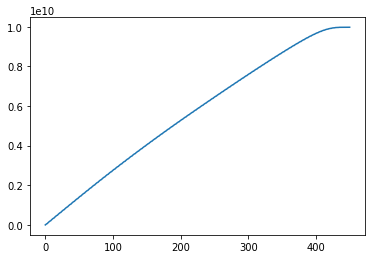

In [9]:
plt.plot(index_cum)

In [10]:
index_cum[:4]

[0, 30602155, 54676876, 68235120]

In [11]:
4320 * 4320 * 3

55987200

In [12]:

_facet_strides = ((0,3), (3,6), (6,7), (7,10), (10,13))
# whether to reshape each face
_facet_reshape = (False, False, False, True, True)
_nfaces = 13

def _faces_to_facets(data):
    # returns a list of facets
    nz, nf, ny, nx = data.shape
    assert nf == _nfaces
    facets = []
    for nfacet, (strides, reshape) in enumerate(zip(_facet_strides, _facet_reshape)):
        face_data = [data[:, slice(nface, nface+1)] for nface in range(*strides)]
        if reshape:
            concat_axis = 3
        else:
            concat_axis = 2
        # todo: use duck typing for concat
        facet_data = dsa.concatenate(face_data, axis=concat_axis)
        facets.append(facet_data)
    return facets

In [13]:
facets = _faces_to_facets(mask)
facets

[dask.array<concatenate, shape=(90, 1, 12960, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 12960, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<getitem, shape=(90, 1, 4320, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 4320, 12960), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 4320, 12960), dtype=bool, chunksize=(1, 1, 4320, 4320)>]

In [14]:
from llcreader import llcmodel

In [15]:
from fsspec.implementations.local import LocalFileSystem

In [16]:
fs = HTTPFileSystem()
path = 'https://data.nas.nasa.gov/ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk'
dtype = np.dtype('>f4')
nk = 90
nx = 4320

In [17]:
local_fs = LocalFileSystem()
local_path = '/Users/rpa/Code/llcreader/Eta.0000010368.data.shrunk'

In [37]:
#start = 0
#end = 30602155
start, end = 6446479451, 6473128103
read_offset = start * dtype.itemsize
read_length  = (end - start) * dtype.itemsize
print(read_length)

106594608


In [38]:
file_obj = fs.open(path, size_policy='get')
file_obj.seek(0)
buffer = file_obj.read(read_length)
data = np.frombuffer(buffer, dtype=dtype)
data.shape

DEBUG:urllib3.connectionpool:Resetting dropped connection: data.nas.nasa.gov
DEBUG:urllib3.connectionpool:https://data.nas.nasa.gov:443 "GET /ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk HTTP/1.1" 200 39893288036
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (7): data.nas.nasa.gov:443
DEBUG:urllib3.connectionpool:https://data.nas.nasa.gov:443 "GET /ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk HTTP/1.1" 206 111837488


(26648652,)

In [20]:
len(buffer)

122408620

In [22]:
file_obj = local_fs.open(local_path)
file_obj.seek(read_offset)
buffer = file_obj.read(read_length)
data = np.frombuffer(buffer, dtype=dtype)
data.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rpa/Code/llcreader/Eta.0000010368.data.shrunk'

In [68]:
30602155 * 4

122408620

In [67]:
type(buffer)

bytes

In [64]:
data.dtype

dtype('>f4')

In [65]:
read_length

489634480

In [21]:
from importlib import reload
llcmodel = reload(llcmodel)
llcmodel

<module 'llcreader.llcmodel' from '/Users/rpa/Code/llcreader/llcreader/llcmodel.py'>

In [58]:
dr = llcmodel.LLCDataRequest(fs, path, dtype, nk, nx, mask=facets, index=index_cum, klevels=[85])
data = dr._build_facet_chunk(1)
data.shape

DEBUG:urllib3.connectionpool:Resetting dropped connection: data.nas.nasa.gov
DEBUG:urllib3.connectionpool:https://data.nas.nasa.gov:443 "GET /ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk HTTP/1.1" 200 39893288036
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (10): data.nas.nasa.gov:443


start, end 9942966452 9945671261


DEBUG:urllib3.connectionpool:https://data.nas.nasa.gov:443 "GET /ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk HTTP/1.1" 206 16062116
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/85.0.0.0 HTTP/1.1" 200 1193817


(1, 1, 12960, 4320)

In [61]:
dsa.concatenate([data[None], data[None]], axis=0)

dask.array<concatenate, shape=(2, 1, 1, 12960, 4320), dtype=>f4, chunksize=(1, 1, 1, 12960, 4320)>

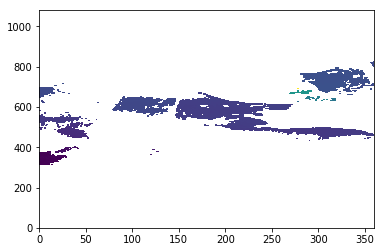

In [59]:
plt.pcolormesh(data[0, 0, ::12, ::12])

In [81]:
dr = llcmodel.LLCDataRequest(local_fs, local_path, dtype, nk, nx, mask=facets, index=index_cum, klevels=[0])
data = dr._build_facet_chunk(0)
data.shape

start, end 0 30602155


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/0.0.0.0 HTTP/1.1" 200 577673


ValueError: cannot reshape array of size 223948800 into shape (1,12960,4320)

In [22]:
def _decompress(data, mask, dtype):
    data_blank = np.full_like(mask, np.nan, dtype=dtype)
    data_blank[mask] = data
    print(mask.shape, data_blank.shape)
    data_blank.shape = mask.shape
    return data_blank

24074721

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG:urllib3.connectionpool:https://storage.googleapis.com:443 "GET /pangeo-ecco/llc/masks/llc_4320_masks.zarr/mask_c/0.0.0.0 HTTP/1.1" 200 577673


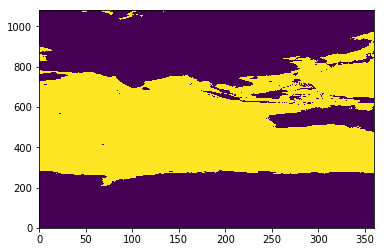

In [52]:
this_mask = facets[1][0].compute()
plt.pcolormesh(this_mask[0, ::12, ::12])

In [51]:
(this_mask == True).sum(), (this_mask == False).sum()

(24074721, 31912479)

In [40]:
this_mask.shape

(1, 12960, 4320)

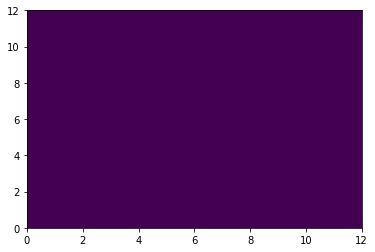

In [25]:
data.shape

(30602155,)

In [27]:
this_mask.sum()

30602155

In [28]:
dc = _decompress(data, this_mask, dtype)

(1, 12960, 4320) (1, 12960, 4320)


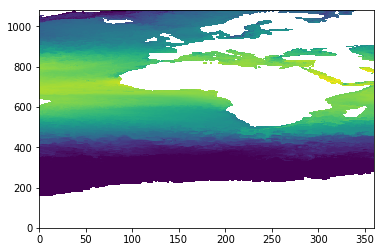

In [29]:
plt.pcolormesh(dc[0, ::12, ::12])

In [92]:
this_mask.sum()

30602155

In [93]:
data.shape[0]/ 4

30602155.0

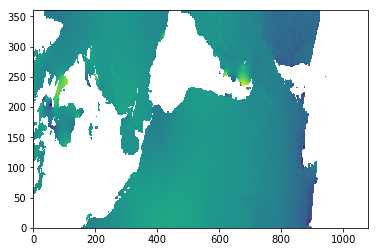

In [45]:
plt.pcolormesh(eta.squeeze()[::12, ::12])

In [69]:
eta_facets = dr.facets()
eta_facets

[dask.array<from-value, shape=(1, 1, 12960, 4320), dtype=>f4, chunksize=(1, 1, 12960, 4320)>,
 dask.array<from-value, shape=(1, 1, 12960, 4320), dtype=>f4, chunksize=(1, 1, 12960, 4320)>,
 dask.array<from-value, shape=(1, 1, 4320, 4320), dtype=>f4, chunksize=(1, 1, 4320, 4320)>,
 dask.array<from-value, shape=(1, 1, 4320, 12960), dtype=>f4, chunksize=(1, 1, 4320, 12960)>,
 dask.array<from-value, shape=(1, 1, 4320, 12960), dtype=>f4, chunksize=(1, 1, 4320, 12960)>]

In [70]:
eta0 = eta_facets[0].compute()

/Users/rpa/Code/llcreader/llcreader/llcmodel.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_blank[mask] = data


ValueError: shape mismatch: value array of shape (55987200,) could not be broadcast to indexing result of shape (12960,4320,12960,4320)

In [49]:
f0 = facets[0].compute()

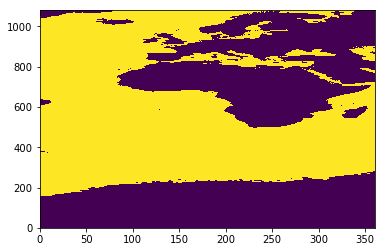

In [50]:
plt.pcolormesh(f0[0, 0, ::12, ::12])

In [51]:
f4 = facets[4].compute()

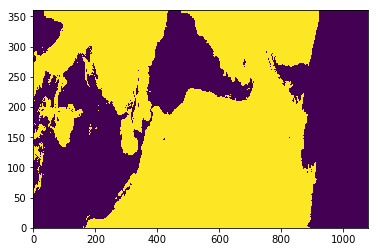

In [53]:
plt.pcolormesh(f4[0, 0, ::12, ::12])

In [33]:
import netCDF4
url = 'http://gliders.ioos.us/thredds/dodsC/deployments/drudnick/sp062-20190201T1350/sp062-20190201T1350.nc3.nc'
netCDF4.Dataset(url)

OSError: [Errno -45] NetCDF: Not a valid data type or _FillValue type mismatch: b'http://gliders.ioos.us/thredds/dodsC/deployments/drudnick/sp062-20190201T1350/sp062-20190201T1350.nc3.nc'

In [34]:
path

'https://data.nas.nasa.gov/ecco/download_data.php?file=/eccodata/llc_4320/compressed/0000010368/Theta.0000010368.data.shrunk'

In [66]:
llcmodel._VAR_METADATA['Eta']

{'attrs': {'long_name': 'Surface Height Anomaly',
  'standard_name': 'ETAN',
  'units': 'm'},
 'dims': ['j', 'i']}